Connected to my_env (Python 3.9.18)

### Comparing ChIP-seq TF to genomic location with sliding window method predictions

This notebook uses ChIP-seq peaks from ChIP-Atlas as the input for calculating sliding window TF to peak binding scores. As the sliding window score attempts to match TFs to peaks, we can check the accuracy of our methods by comparing which TFs are predicted to bind the ChIP-seq peaks against the TFs that actually bound those locations.

The first thing that we need to do is to download and clean the ChIP-seq dataset to only contain the TF `gene_id`s and the formatted `peak_id`s.

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

In [ ]:
import os
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
output_dir = os.path.join(base_dir, "output/chipseq_sliding_window")
tmp_dir = os.path.join(output_dir, "tmp")

os.makedirs(ground_truth_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

In [ ]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

chip_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_bed = pybedtools.BedTool(chip_bed_file)
chip_bed_df = chip_bed.to_dataframe()
chip_bed_nohead = chip_bed_df.iloc[1:, :].dropna()

chip_bed_nohead["gene_id"] = chip_bed_nohead["name"].apply(extract_gene_name)
chip_bed_cleaned = chip_bed_nohead[["chrom", "start", "end", "gene_id"]]

# Set the peak_id as the formatted peak location
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

chip_tf_to_peak = chip_bed_cleaned[["gene_id", "peak_id"]]
chip_tf_to_peak

,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677


Now that we have the ChIP-Atlas peaks in the format that we want, we can save it to the ground truth directory for later

In [ ]:
chip_tf_to_peak.to_csv(os.path.join(ground_truth_dir, "chipatlas_mESC.csv"), header=True, index=False)

### Creating the Homer peaks file

Next, we need to format the peaks to follow the same requirements as the Homer peaks file. The sliding window method also uses this format for convenience.

> HOMER peak files should have at minimum 5 columns (separated by TABs, additional columns will be ignored:
> - Column1: Unique Peak ID
> - Column2: chromosome
> - Column3: starting position
> - Column4: ending position
> - Column5: Strand (+/- or 0/1, where 0="+", 1="-")

In [ ]:
# Format the DataFrame to follow the requirements for the Homer peaks file (used for both Homer and sliding window)
homer_peaks = chip_bed_cleaned[["peak_id", "chrom", "start", "end"]]
homer_peaks = homer_peaks.rename(columns={"peak_id":"PeakID", "chrom":"chr"})
homer_peaks["strand"] = ["."] * len(homer_peaks)
homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)
homer_peaks

,PeakID,chr,start,end,strand
1,chr1:3003564-3003922,chr1,3003564,3003922,.
2,chr1:3012605-3012815,chr1,3012605,3012815,.
3,chr1:3012635-3012824,chr1,3012635,3012824,.
4,chr1:3031387-3031654,chr1,3031387,3031654,.
5,chr1:3031454-3031677,chr1,3031454,3031677,.
...,...,...,...,...,...
7624387,chrY_JH584303_random:135985-136047,chrY_JH584303_random,135985,136047,.
7624388,chrY_JH584303_random:135985-136048,chrY_JH584303_random,135985,136048,.
7624389,chrY_JH584303_random:135986-136045,chrY_JH584303_random,135986,136045,.
7624390,chrY_JH584303_random:135989-136043,chrY_JH584303_random,135989,136043,.


This is a huge file - we dont need to test the method using all of them. We will take a sample to run the scoring on.

In [ ]:
homer_peaks_sample = homer_peaks.sample(frac=0.05)

If we save the ChIP-seq peaks as `homer_peaks.txt` to the `tmp` directory of the output folder, then they will be used to calculate the sliding window and Homer scores

In [ ]:
homer_peak_path = os.path.join(tmp_dir, "homer_peaks.txt")
homer_peaks_sample.to_csv(homer_peak_path, sep="\t", header=False, index=False)

Next, we run `run_sliding_window_on_chipseq_peaks.sh` in the `dev/testing_scripts` directory

```bash
#!/bin/bash -l
#SBATCH --partition=memory
#SBATCH --nodes=1
#SBATCH -c 32
#SBATCH --mem=124G
#SBATCH -o /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/LOGS/chipseq_sliding_window.log
#SBATCH -e /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/LOGS/chipseq_sliding_window.err

set -euo pipefail

source activate my_env

cd "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"

poetry run python "src/grn_inference/pipeline/sliding_window_tf_peak_motifs.py" \
    --tf_names_file "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/motif_information/mm10/TF_Information_all_motifs.txt" \
    --meme_dir "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/motif_information/mm10/mm10_motif_meme_files" \
    --reference_genome_dir '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/reference_genome/mm10' \
    --atac_data_file "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/DS011_mESC_sample1/DS011_mESC_ATAC_processed.parquet" \
    --rna_data_file "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/input/DS011_mESC/DS011_mESC_sample1/DS011_mESC_RNA_processed.parquet" \
    --output_dir "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window" \
    --species "mm10" \
    --num_cpu "32" \
    --fig_dir "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window"
```

In [57]:
!sbatch /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/testing_scripts/run_sliding_window_on_chipseq_peaks.sh

Submitted batch job 3373183


Once the sliding window calculation is done, we can read in the output.

In [56]:
sliding_window_output = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/sliding_window_tf_to_peak_score.parquet"
sliding_window_df = pd.read_parquet(sliding_window_output, engine="pyarrow")
sliding_window_df = sliding_window_df.reset_index(drop=True)
sliding_window_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/sliding_window_tf_to_peak_score.parquet'

We can use the `chip_tf_to_peak` object that we created from the ChIP-Atlas file to check our work. Since we sampled the ChIP-Atlas peaks before running the sliding window calculations, we need to subset `chip_tf_to_peak` to only contain those peaks.

In [ ]:
chip_tf_to_peak_sub = chip_tf_to_peak[chip_tf_to_peak["peak_id"].isin(sliding_window_df["peak_id"])]
chip_tf_to_peak_sub

,gene_id,peak_id
30,Cebpa,chr1:3059708-3059807
43,Ncor2,chr1:3094784-3095161
50,Ncor2,chr1:3094854-3095103
63,Ncor2,chr1:3113649-3113870
96,Ncor2,chr1:3120165-3120649
...,...,...
7624325,Rest,chrY_JH584301_random:56821-56874
7624328,Rest,chrY_JH584301_random:56826-56874
7624342,Epitope,chrY_JH584301_random:130529-130620
7624360,Atrx,chrY_JH584301_random:206615-206677


We then combine the TF-peak mapping from ChIP-Atlas with the TF-peak mapping from the sliding window score by merging the two DataFrames on `peak_id`.

In [ ]:
merged_df = pd.merge(chip_tf_to_peak_sub, sliding_window_df, on="peak_id", how="inner")
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "sliding_window_gene"})
merged_df = merged_df[["chip_gene", "sliding_window_gene", "peak_id", "sliding_window_score"]]
merged_df

,chip_gene,sliding_window_gene,peak_id,sliding_window_score
0,Cebpa,Arid5a,chr1:3059708-3059807,0.172386
1,Cebpa,Ebf4,chr1:3059708-3059807,0.000000
2,Cebpa,Egr1,chr1:3059708-3059807,0.218335
3,Cebpa,Elf2,chr1:3059708-3059807,0.236552
4,Cebpa,Emx2,chr1:3059708-3059807,0.164790
...,...,...,...,...
21845742,Rest,Zfp182,chrY_JH584302_random:139711-139760,0.000000
21845743,Rest,Zfp282,chrY_JH584302_random:139711-139760,0.041938
21845744,Rest,Zfp653,chrY_JH584302_random:139711-139760,0.166139
21845745,Rest,Zfp692,chrY_JH584302_random:139711-139760,0.100401


In [ ]:
merged_df.to_csv(os.path.join(output_dir, "chipseq_sliding_window_merged.csv"), header=True, index=False)

We can extract the correct predictions and the incorrect predictions, and see how the sliding window scores vary between them.

In [38]:
correct_predictions = merged_df[merged_df["chip_gene"] == merged_df["sliding_window_gene"]]
incorrect_predictions = merged_df[merged_df["chip_gene"] != merged_df["sliding_window_gene"]]

print(f"Num correct predictions: {len(correct_predictions)}")
print(f"Num incorrect predictions: {len(incorrect_predictions)}")

Num correct predictions: 12109
Num incorrect predictions: 21833638


Since each TF and peak has a potential binding score, there will be a lot more incorrect predictions than correct predictions. We will sample each DataFrame by the one with the minimum number of rows so they are equal in length.

In [43]:
correct_prediction_scores = correct_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Correct TF Binding Predictions").reset_index(drop=True)

incorrect_prediction_scores = incorrect_predictions["sliding_window_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Incorrect TF Binding Predictions").reset_index(drop=True)

print(f"Num correct predictions: {len(correct_prediction_scores)}")
print(f"Num incorrect predictions: {len(incorrect_prediction_scores)}")

Num correct predictions: 12109
Num incorrect predictions: 12109


Now that we have extracted the correct and incorrect scores, we will merge them to create a new dataframe containing just the correct and incorrect scores.

In [44]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

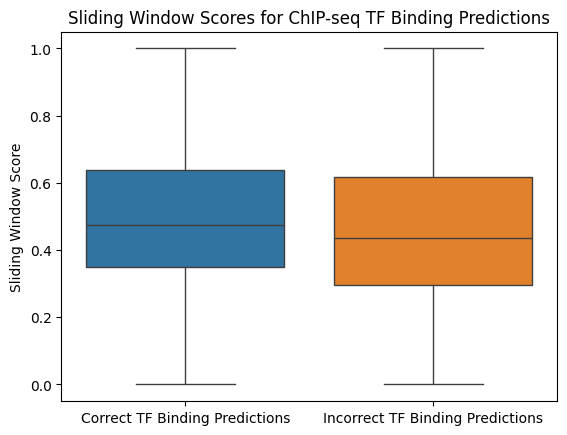

In [48]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df)
a.set_ylabel("Sliding Window Score")
a.set_title("Sliding Window Scores for ChIP-seq TF Binding Predictions")
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_boxplot.png", dpi=200)

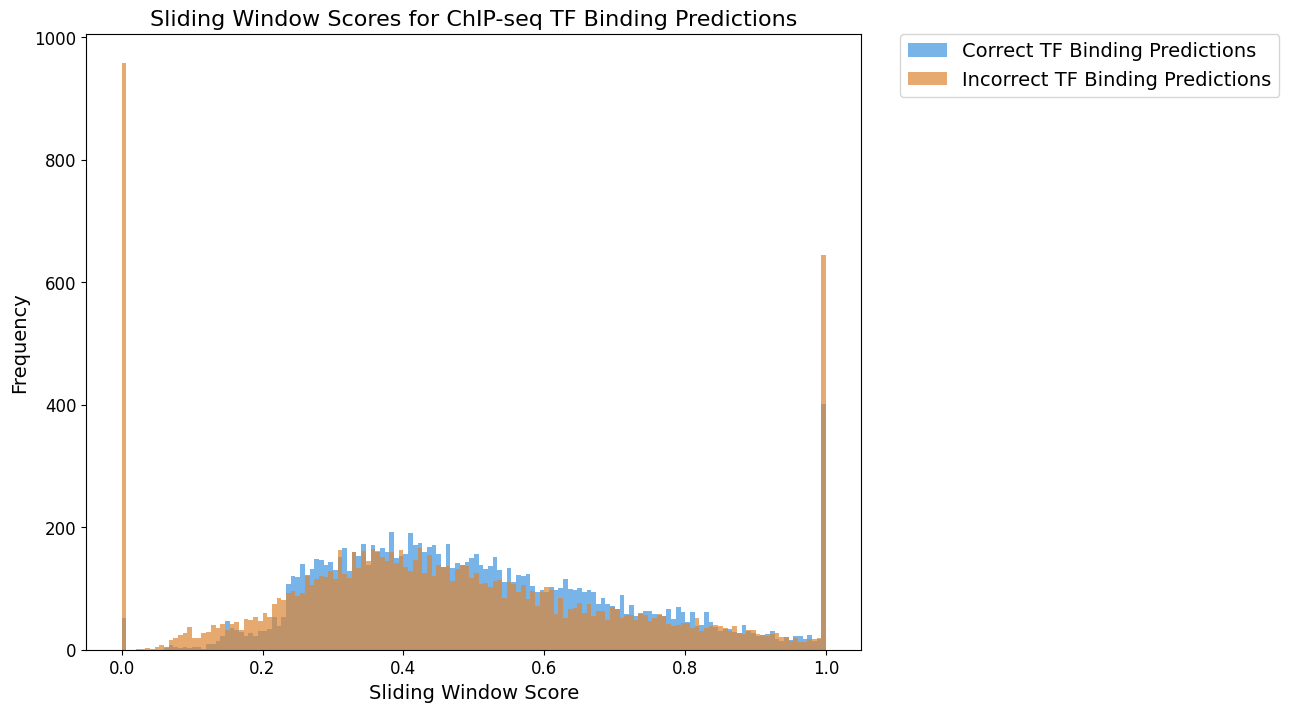

In [55]:
plt.figure(figsize=(10,8))
plt.hist(
    pred_df["Correct TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    pred_df["Incorrect TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#dc8634',
    label="Incorrect TF Binding Predictions"
)
plt.title("Sliding Window Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Sliding Window Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_histogram.png", dpi=200)